# NLP text classification -- product classification

### Problem Statement: classify products into three categories given product names

In [20]:
from logging import warning
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

import re
import string
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from imblearn.over_sampling import SMOTE
from sklearn import utils
from sklearn.model_selection import  train_test_split
from sklearn.utils.class_weight import compute_class_weight
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Embedding, Dense, Dropout, Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import multiprocessing
cores = multiprocessing.cpu_count()

In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/superstore_products_new.csv', usecols=['product_name','category'])

In [7]:
df.loc[df['product_name'].duplicated()]

,category,product_name


[]

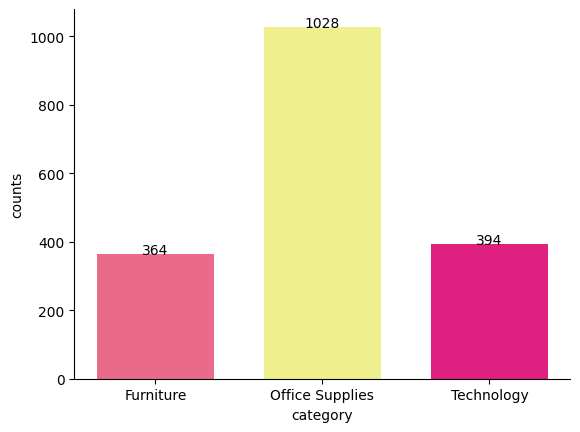

In [8]:
category_counts = df.groupby(['category']).size().to_frame().rename(columns={0:'counts'})
sns.barplot(category_counts, y='counts', x='category', hue='category', palette=['#FF5580','#FFFF80', '#FF0080'], width=0.7)
for i, c in enumerate(category_counts['counts']):
  plt.text(i, c, str(c), ha='center')
sns.despine()
plt.plot()

### define function for text pre-pocessing and tokenisation


In [9]:
def prep_tokenised(text:str, token:bool=True)-> str|list[str]:
  trans_string = string.digits + string.punctuation
  trans_table = dict.fromkeys(map(ord, trans_string), ' ')
  text = text.translate(trans_table)
  text = re.sub(r"[^\w\s]|\s+", ' ', text)
  text = text.lower().strip()
  text = ' '.join([word for word in text.split() if word not in stopwords.words('english') and len(word)>1])
  if token:
    return word_tokenize(text)
  else:
    return text

In [10]:
df['prep_product_name'] = df['product_name'].apply(lambda txt: prep_tokenised(txt, False))
df['tokens'] = df['product_name'].apply(prep_tokenised)
df['category'] = df['category'].apply(str.lower)

In [11]:
furniture_generated = ' '.join([x for x in df[df['category']=='furniture']['prep_product_name'].values])
office_generated = ' '.join([x for x in df[df['category']=='office supplies']['prep_product_name'].values])
tech_generated = ' '.join([x for x in df[df['category']=='technology']['prep_product_name'].values])

### visualisng words in each product category on wordcloud

In [15]:
palette= ['#FFFF80', '#FFAA80', '#FF5580', '#FF0080']
cmap = ListedColormap(palette, name='custom')

In [21]:
def wordcloud(text:str, mask=None):
  return WordCloud(height=400,  width=800, scale=2,
                   background_color = 'black', colormap=cmap.reversed(), collocations=False).generate(text)

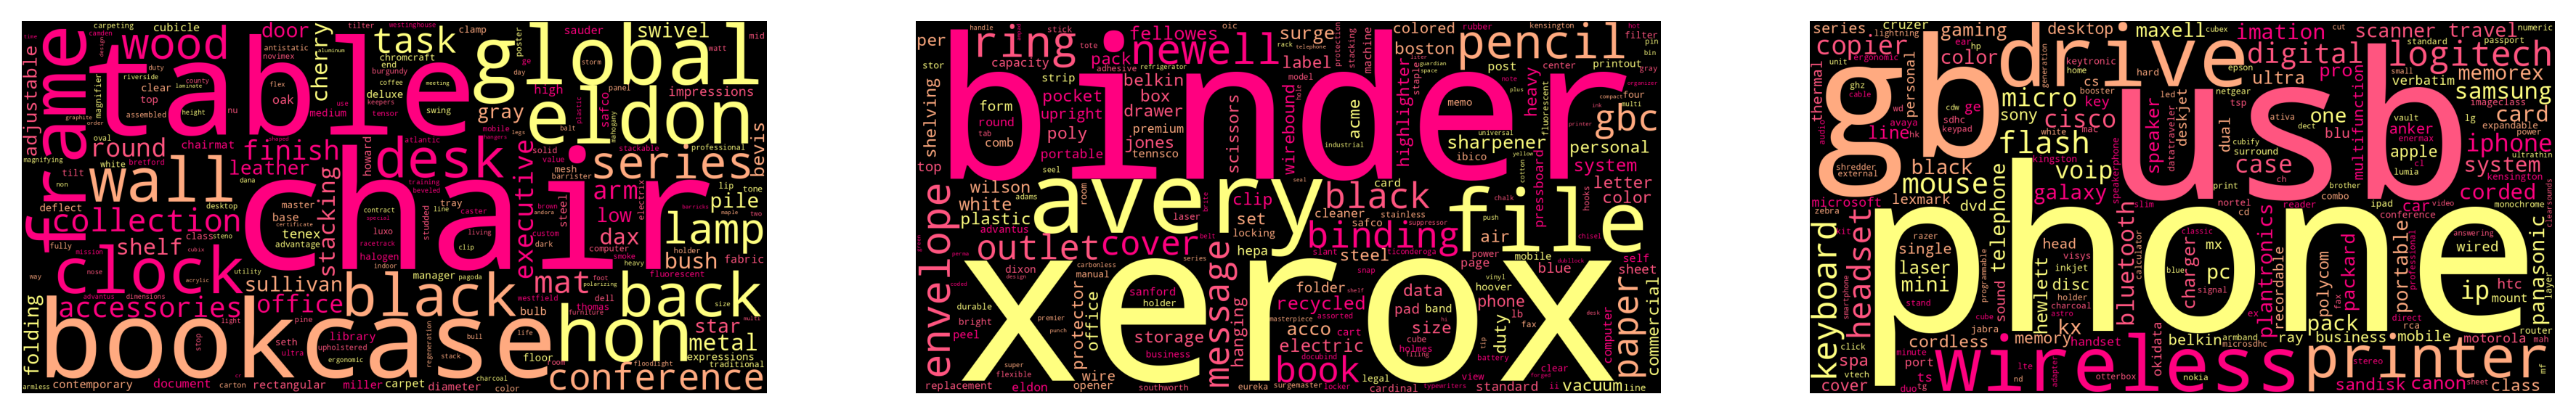

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,7), dpi=300)
ax[0].imshow(wordcloud(furniture_generated))
ax[0].axis('off')
ax[1].imshow(wordcloud(office_generated))
ax[1].axis('off')
ax[2].imshow(wordcloud(tech_generated))
ax[2].axis('off')
plt.show()

In [23]:
len_list = [len(tk) for tk in df['tokens']]
print(max(len_list), sum(len_list))

16 8751


# Word Embedding

### Create tag document

In [24]:
tagged_doc = df.apply(lambda dt: TaggedDocument(words=dt['tokens'], tags=[dt.category]), axis=1)
tagged_doc.values

array([TaggedDocument(words=['message', 'book', 'one', 'form', 'per', 'page'], tags=['office supplies']),
       TaggedDocument(words=['gummed', 'flap', 'white', 'envelopes', 'box'], tags=['office supplies']),
       TaggedDocument(words=['self', 'seal', 'white', 'envelopes'], tags=['office supplies']),
       ...,
       TaggedDocument(words=['zebra', 'zazzle', 'fluorescent', 'highlighters'], tags=['office supplies']),
       TaggedDocument(words=['zebra', 'zm', 'thermal', 'label', 'printer'], tags=['technology']),
       TaggedDocument(words=['zipper', 'ring', 'binder', 'pockets'], tags=['office supplies'])],
      dtype=object)

### build vocabulary from the tagged document using Doc2Vec and train the model

In [25]:
d2v_model = Doc2Vec(dm=1, vector_size=50, window=5,
                    min_count=1, workers=cores)
d2v_model.build_vocab([x for x in tagged_doc.values])

In [26]:
print(len(d2v_model.wv.index_to_key), d2v_model.dv.vectors.shape)
d2v_model.corpus_total_words, d2v_model.corpus_count

1924 (3, 50)


(8751, 1786)

In [27]:
for epoch in range(100):
    d2v_model.train(utils.shuffle([x for x in tagged_doc.values]), total_examples=len(tagged_doc.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

# d2v_model.train(tagged_doc.values, total_examples=d2v_model.corpus_count, epochs=30)

In [28]:
d2v_model.dv.most_similar('technology')

[('office supplies', 0.9764045476913452), ('furniture', 0.9679470062255859)]

In [29]:
d2v_model.wv.most_similar('phone')

[('headset', 0.9990721344947815),
 ('bluetooth', 0.9990566968917847),
 ('mouse', 0.9989166259765625),
 ('color', 0.9986019730567932),
 ('labels', 0.9981573820114136),
 ('cordless', 0.9981116056442261),
 ('wireless', 0.9980515241622925),
 ('set', 0.998005747795105),
 ('power', 0.9979413747787476),
 ('line', 0.997808039188385)]

#### save trained model

In [55]:
d2v_model.save('/content/drive/MyDrive/Colab Notebooks/doc2vec')

# LSTM

#### split train test data

In [128]:
X, y = df['prep_product_name'].values, df['category'].values

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=df['category'].values, random_state = 1000)

In [130]:
MAX_WORD = 10000
MAX_SEQ_LEN = 30

#### create tokens and

In [131]:
def token_padding_seq(maxword:int, maxlen:int, X:pd.DataFrame|list):
  tokeniser = Tokenizer(num_words=maxword)
  tokeniser.fit_on_texts(X)
  X = tokeniser.texts_to_sequences(X)
  X = pad_sequences(X, maxlen=maxlen, truncating='post')
  return X, tokeniser

In [132]:
tokeniser = Tokenizer(num_words=MAX_WORD)
tokeniser.fit_on_texts(X_train)

X_train = tokeniser.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, truncating='post')

X_test = tokeniser.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LEN, truncating='post')

In [133]:
print('unique tokens:',len(tokeniser.index_word))
print('padded shape:', X_train.shape)
vocab_size = len(tokeniser.index_word)

unique tokens: 1728
padded shape: (1428, 30)


In [134]:
# sm_X_train, sm_y_train = SMOTE().fit_resample(X_train,y_train)

#### one-hot encoded on our class labels

In [135]:
encoded_y_train = pd.get_dummies(y_train, dtype=int).values
encoded_y_test = pd.get_dummies(y_test, dtype=int).values

#### compute class weight for imbalanced class data

In [136]:
np.unique(y_train)

array(['furniture', 'office supplies', 'technology'], dtype=object)

In [137]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {i: w for i, w in enumerate(class_weight)}

#### created embedding matrix from our trained d2v model

In [150]:
embed_weights = np.zeros((vocab_size+1, 50))
train_vocabs = tokeniser.index_word
for i, v in train_vocabs.items():
  if v in d2v_model.wv.index_to_key:
    # print(i, v)
    embed_weights[i] = d2v_model[v]

In [151]:
embed_weights.shape

(1729, 50)

#### LSTM model without pre-trained doc2vec embeding matrix
- initialising the embedding layer and weights would be learning during training

In [145]:
mdl = Sequential()
mdl.add(Input(X_train[0,:].shape))
mdl.add(Embedding(vocab_size+1, 50, input_length=MAX_SEQ_LEN))
mdl.add(SpatialDropout1D(0.1))
# mdl.add(Conv1D())
# mdl.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
mdl.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
mdl.add(GlobalMaxPooling1D())
mdl.add(Dense(64, activation='relu'))
mdl.add(Dropout(0.1))
mdl.add(Dense(3, activation='softmax'))
mdl.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ (None, 30, 50)              │          86,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_13                 │ (None, 30, 50)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_12              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,245 (469.71 KB)

 Trainable params: 120,245 (469.71 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
mdl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Adam(learning_rate=1e-3)

In [147]:
reLR = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
history = mdl.fit(X_train, encoded_y_train, validation_data=(X_test, encoded_y_test),
                  epochs=50, batch_size=64, verbose=1, class_weight=class_weight, callbacks=[reLR])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3620 - loss: 1.0949 - val_accuracy: 0.8128 - val_loss: 1.0797 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7042 - loss: 1.0491 - val_accuracy: 0.6704 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7951 - loss: 0.7492 - val_accuracy: 0.8464 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8909 - loss: 0.3523 - val_accuracy: 0.9162 - val_loss: 0.2658 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9688 - loss: 0.1220 - val_accuracy: 0.9497 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9850 - loss: 0.0586 - val_accuracy: 0.9609 - val_loss: 0.1381 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9881 - loss: 0.0323 - val_acc

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0479e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9778 - loss: 0.1181
loss:1.9693996364367194e-05
train accuaracy:1.0
loss:0.14374805986881256
test accuaracy:0.9692737460136414


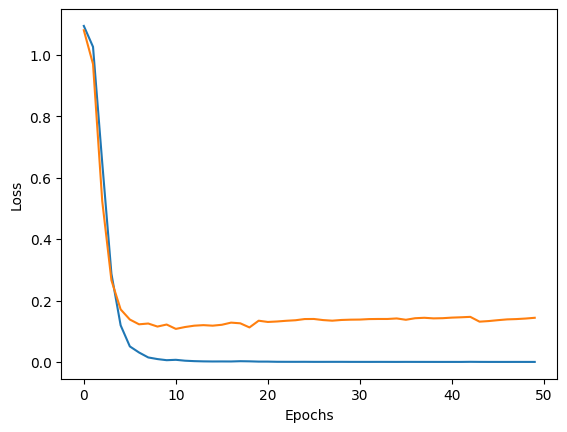

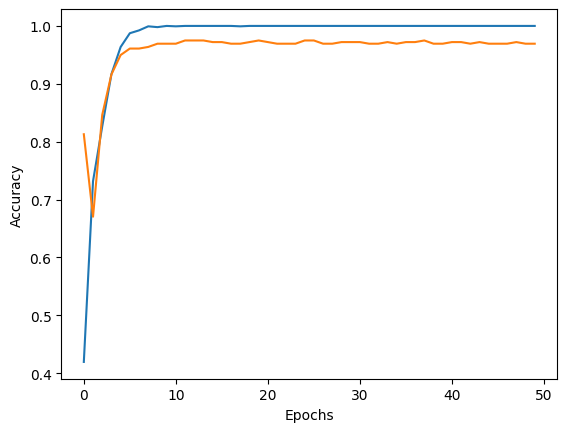

In [191]:
loss_train, acc_train = mdl.evaluate(X_train, encoded_y_train)
loss_test, acc_test = mdl.evaluate(X_test, encoded_y_test)
print(f'loss:{loss_train}\ntrain accuaracy:{acc_train}')
print(f'loss:{loss_test}\ntest accuaracy:{acc_test}')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


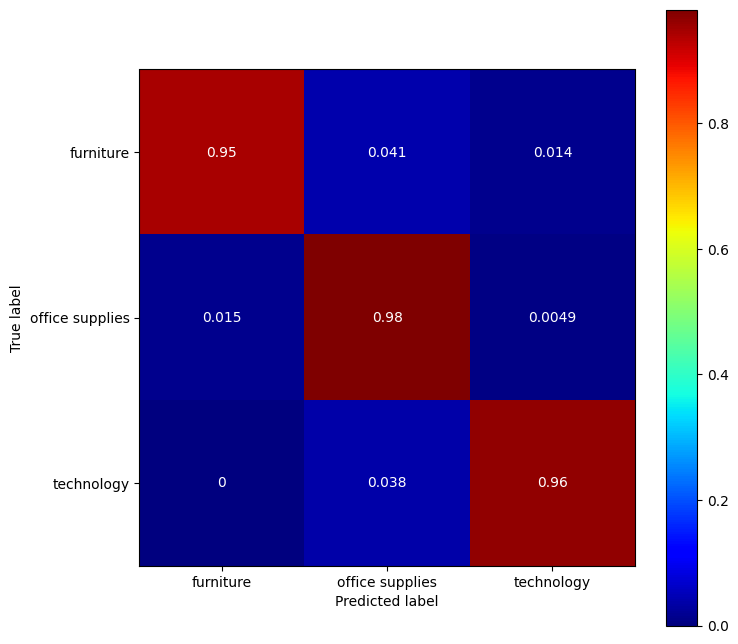

In [192]:
y_pred = mdl.predict(X_test)
y_pred = y_pred.argmax(-1)
y_test_class = np.argmax(encoded_y_test, axis=1)

cf = confusion_matrix(y_test_class, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(cf, display_labels=['furniture', 'office supplies', 'technology'])
disp.plot(ax=ax, cmap='jet', text_kw={'color':'white'})
plt.show()

The accuracy on test set is around 0.97 or 97% suggesting relatively good performace of the model. The model could do well on classifying office supply category product as expected. And there is no misclassication on technology between furniture product.

#### LSTM with pre-trained doc2vec embedding matrix

In [171]:
model = Sequential()
model.add(Input(X_train[0,:].shape))
model.add(Embedding(vocab_size+1, embed_weights.shape[1],
                     weights=[embed_weights], input_length=MAX_SEQ_LEN, trainable=False))
model.add(SpatialDropout1D(0.1))
# model.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True)))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 30, 50)              │          86,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_18                 │ (None, 30, 50)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 30, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_17              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,245 (469.71 KB)

 Trainable params: 33,795 (132.01 KB)

 Non-trainable params: 86,450 (337.70 KB)

In [172]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) #Adam(learning_rate=1e-3)

In [173]:
reLR2 = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
new_history = model.fit(X_train, encoded_y_train, validation_data=(X_test, encoded_y_test),
                  epochs=50, batch_size=64, verbose=1, class_weight=class_weight, callbacks=[reLR2])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.4384 - loss: 1.0591 - val_accuracy: 0.4106 - val_loss: 1.1192 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.5067 - loss: 1.0366 - val_accuracy: 0.6425 - val_loss: 0.9646 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.6081 - loss: 0.9581 - val_accuracy: 0.6341 - val_loss: 0.8991 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6605 - loss: 0.8189 - val_accuracy: 0.6676 - val_loss: 0.8064 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7079 - loss: 0.7219 - val_accuracy: 0.6844 - val_loss: 0.7677 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7059 - loss: 0.7019 - val_accuracy: 0.6620 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.7197 - loss: 0.7269 - val_a

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8573 - loss: 0.3874
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8377 - loss: 0.4991
loss:0.39676058292388916
train accuaracy:0.8529411554336548
loss:0.5092193484306335
test accuaracy:0.8128491640090942


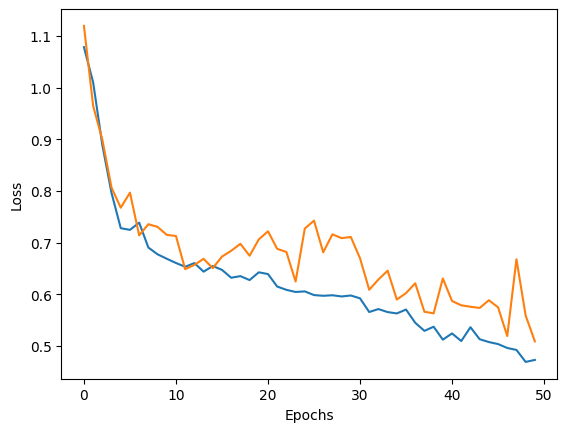

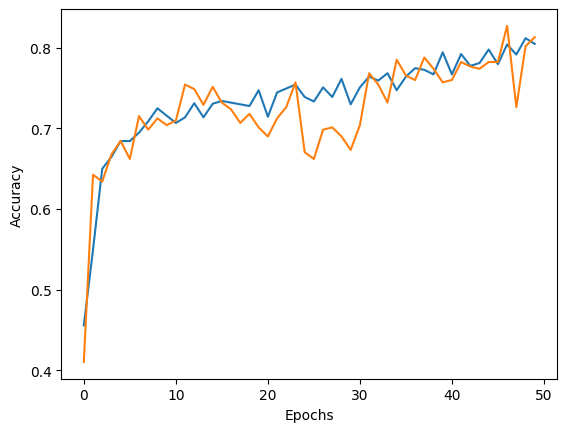

In [174]:
loss_train, acc_train = model.evaluate(X_train, encoded_y_train)
loss, acc = model.evaluate(X_test, encoded_y_test)
print(f'loss:{loss_train}\ntrain accuaracy:{acc_train}')
print(f'loss:{loss}\ntest accuaracy:{acc}')

plt.plot(new_history.history['loss'])
plt.plot(new_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(new_history.history['accuracy'])
plt.plot(new_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


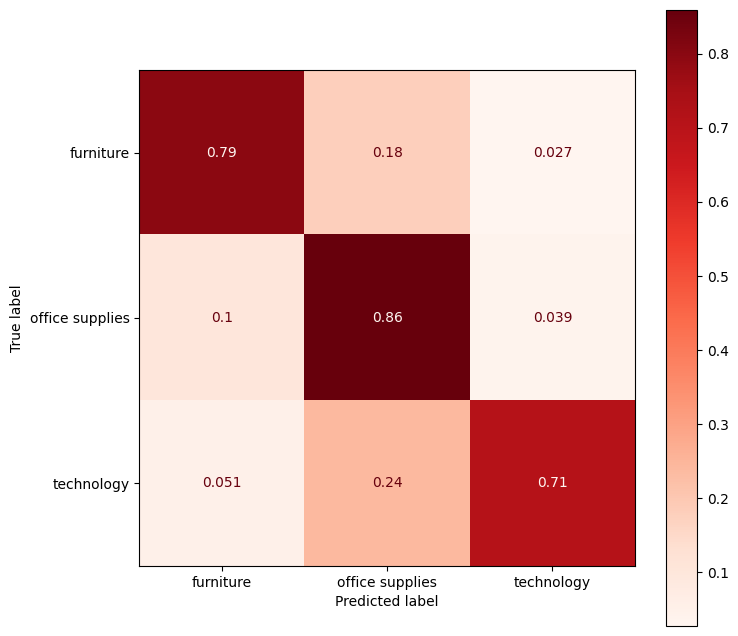

In [176]:
y_pred_new = model.predict(X_test)
y_pred_new = y_pred_new.argmax(-1)
y_test_class = np.argmax(encoded_y_test, axis=1)

cf = confusion_matrix(y_test_class, y_pred_new, normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(cf, display_labels=['furniture', 'office supplies', 'technology'])
disp.plot(ax=ax, cmap='Reds')
plt.show()

The accuracy on the test set is around 0.81 or 81% relative to the train set score, around 85%, the model does not seem to be overfitting as the difference is relatively low. However, the performace moght not be satisfying since the test accuracy score reduces about 16.5% from the previous model.

#### LSTM initialised with pre-trained d2v embedding matrix and new weights learnt during training
- with trainable = True

In [179]:
lstm_mdl = Sequential()
lstm_mdl.add(Input(X_train[0,:].shape))
lstm_mdl.add(Embedding(embed_weights.shape[0], embed_weights.shape[1],
                       input_length=MAX_SEQ_LEN, weights=[embed_weights],
                        trainable=True))
lstm_mdl.add(SpatialDropout1D(0.1))
lstm_mdl.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, return_sequences=True))
lstm_mdl.add(GlobalMaxPooling1D())
lstm_mdl.add(Dense(64, activation='relu'))
lstm_mdl.add(Dropout(0.1))
lstm_mdl.add(Dense(3, activation='softmax'))
lstm_mdl.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_21 (Embedding)             │ (None, 30, 50)              │          86,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_21                 │ (None, 30, 50)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 30, 64)              │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_18              │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,245 (469.71 KB)

 Trainable params: 120,245 (469.71 KB)

 Non-trainable params: 0 (0.00 B)

In [181]:
lstm_mdl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [182]:
lstm_history= lstm_mdl.fit(X_train, encoded_y_train, validation_data=(X_test, encoded_y_test),
                  epochs=50, batch_size=64, verbose=1, class_weight=class_weight, callbacks=[reLR])

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.3556 - loss: 1.0686 - val_accuracy: 0.5866 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5899 - loss: 0.9781 - val_accuracy: 0.6592 - val_loss: 0.8598 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7311 - loss: 0.6767 - val_accuracy: 0.7430 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8335 - loss: 0.4310 - val_accuracy: 0.8911 - val_loss: 0.3142 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9306 - loss: 0.2283 - val_accuracy: 0.9330 - val_loss: 0.2269 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9447 - loss: 0.1816 - val_accuracy: 0.9330 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9662 - loss: 0.1002 - val_ac

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0728e-05
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9728 - loss: 0.1430
loss:7.557482604170218e-05
train accuaracy:1.0
loss:0.16246318817138672
test accuaracy:0.9692737460136414


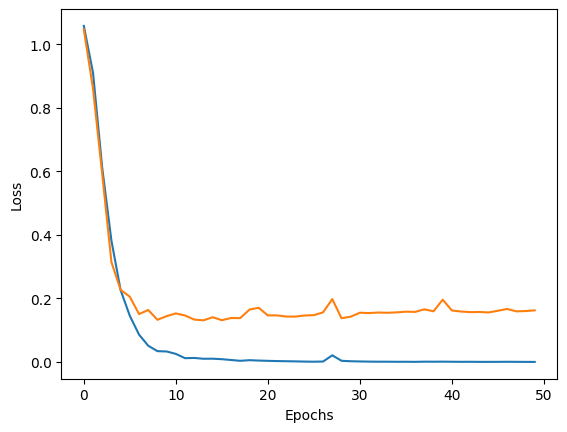

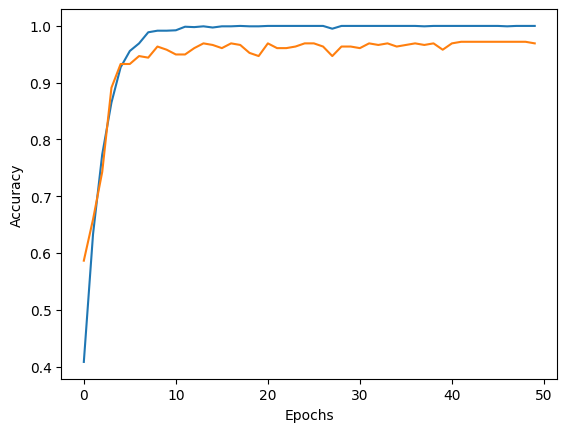

In [193]:
loss_train, acc_train = lstm_mdl.evaluate(X_train, encoded_y_train)
loss_test, acc_test = lstm_mdl.evaluate(X_test, encoded_y_test)
print(f'loss:{loss_train}\ntrain accuaracy:{acc_train}')
print(f'loss:{loss_test}\ntest accuaracy:{acc_test}')

plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


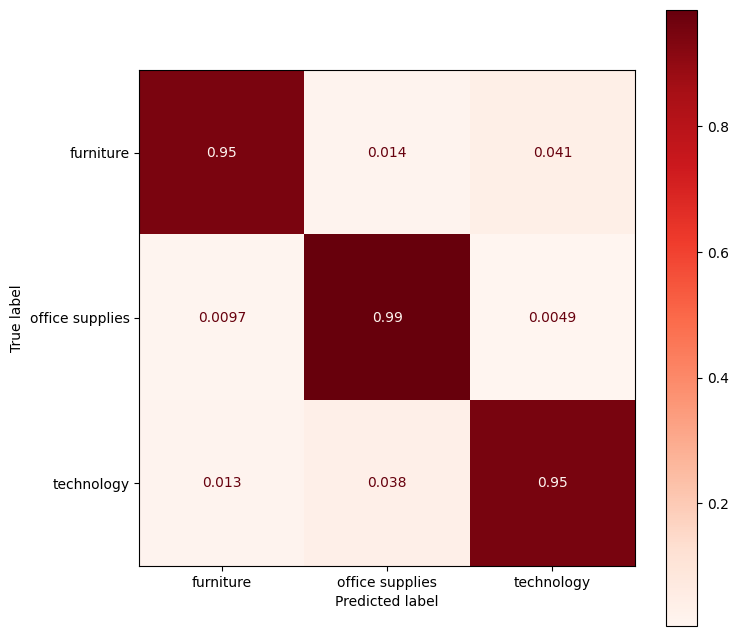

In [194]:
y_pred_lstm = lstm_mdl.predict(X_test)
y_pred_lstm = y_pred_lstm.argmax(-1)

cf = confusion_matrix(y_test_class, y_pred_lstm, normalize='true')
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(cf, display_labels=['furniture', 'office supplies', 'technology'])
disp.plot(ax=ax, cmap='Reds')
plt.show()